# CS 176 Project

In [1]:
# load libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# states conversion dict that has all of the universal states
states = {'AK':'Alaska', 'AL':'Alabama', 'AR':'Arkansas', 'AZ':'Arizona', 'CA':'California', 'CO':'Colorado', 'CT':'Connecticut', 'DC':'District Of Columbia', 'DE':'Delaware', 'FL':'Florida', 'GA':'Georgia', 'HI':'Hawaii', 'IA':'Iowa', 'ID':'Idaho', 'IL':'Illinois', 'IN':'Indiana', 'KS':'Kansas', 'KY':'Kentucky', 'LA':'Louisiana', 'MA':'Massachusetts', 'MD':'Maryland', 'ME':'Maine', 'MI':'Michigan', 'MN':'Minnesota', 'MO':'Missouri', 'MS':'Mississippi', 'MT':'Montana', 'NC':'North Carolina', 'ND':'North Dakota', 'NE':'Nebraska', 'NH':'New Hampshire', 'NJ':'New Jersey', 'NM':'New Mexico', 'NV':'Nevada', 'NY':'New York', 'OH':'Ohio', 'OK':'Oklahoma', 'OR':'Oregon', 'PA':'Pennsylvania', 'RI':'Rhode Island', 'SC':'South Carolina', 'SD':'South Dakota', 'TN':'Tennessee', 'TX':'Texas', 'UT':'Utah', 'VA':'Virginia', 'VT':'Vermont', 'WA':'Washington', 'WI':'Wisconsin', 'WV':'West Virginia', 'WY':'Wyoming'}

# read in the csv files
aqiDF = pd.read_csv('./data/annual_aqi_by_county_2021.csv')
copdDF = pd.read_csv('./data/County_COPD_prevalence.csv').rename(columns = {"StateDesc": "State"})
popDF = pd.read_csv('./data/PopulationEstimates.csv', encoding="latin-1").rename(columns = {"Area_Name": "County"})

# cleaning all of the generic data for the us and states and only selecting the population estimates for 2021
popDF = popDF[(popDF.State != "US") & (popDF.State != popDF.County)]

# using a pivot table to restructure the dataset to include the attributes as columns with their values underneath
popDF = popDF.pivot(
    index=['FIPStxt', 'State', 'County'],
    columns='Attribute',
    values='Value'
).reset_index()


# remove all of the " country" or " parish" or similar from the end of the population dataframe's county names
popDF.County = popDF.County.map(lambda x: " ".join(x.split(" ")[:-1]))

# putting the aqi and copd into title case
aqiDF.State = aqiDF.State.str.title()
copdDF.State = copdDF.State.str.title()

# filtering for only the universal states in all of the dataframes
copdDF = copdDF[copdDF.State.isin(states.values())]
aqiDF = aqiDF[aqiDF.State.isin(states.values())]

# converting the popDF's state abbreviations into the full state names
popDF.State = popDF.State.map(states)
# only taking 2021 population estimates so that other years cann't be merged in. Leave popdf for fips conversions later
popDF_slim = popDF.loc[:, ["State", "County", "FIPStxt", "POP_ESTIMATE_2021"]]



In [3]:
# merge the dataframe using inner merges on the state county values
mergeTemp = pd.merge(aqiDF, popDF_slim, on=["State", "County"])
mergeFull = pd.merge(mergeTemp, copdDF, on=["State", "County"])

# merge just the copd values so that for COPD map missing AQI will not affect the map
COPDMerge = pd.merge(copdDF, popDF_slim, on=["State", "County"])

# mergeFull.head()
print(mergeFull.columns) # Print out all of the data columns that we have access to
print(len(mergeFull)) # Print total number of entries to see how many counties we end up with

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'FIPStxt', 'POP_ESTIMATE_2021',
       'FullGeoName', 'LocationID', 'Public_Health_Jurisdiction',
       'Percent_COPD', '95% Confidence Interval', 'Quartile'],
      dtype='object')
961


In [4]:
#this cell will sort the new data set by worst air quality meaning the highest aqi
#this sorts so highest median aqi is first
worst_aqi = mergeFull.sort_values("Median AQI", ascending=False)
#this looks at the most important attributes of the 10 worst counties 
worst_aqi.loc[:, ["State", "County", "Median AQI", "Percent_COPD", "POP_ESTIMATE_2021"]].head(10)

,State,County,Median AQI,Percent_COPD,POP_ESTIMATE_2021
20,Arizona,Maricopa,122,5.4,4499438.0
68,California,Riverside,89,5.3,2453399.0
71,California,San Bernardino,87,5.6,2193087.0
52,California,Kern,84,6.7,912709.0
88,California,Tulare,81,6.7,477176.0
55,California,Los Angeles,79,4.7,9809462.0
24,Arizona,Pinal,70,6.3,448993.0
47,California,Fresno,68,6.1,1013103.0
72,California,San Diego,67,4.7,3274432.0
67,California,Plumas,67,6.1,19958.0


In [5]:
# sorting the dataframe by the percentage of COPD residents
sorted_by_copd = mergeFull.sort_values("Percent_COPD", ascending=False)
#this looks at the most important attributes of the 10 worst counties 
sorted_by_copd.loc[:, ["State", "County", "Median AQI", "Percent_COPD", "POP_ESTIMATE_2021"]].head()

,State,County,Median AQI,Percent_COPD,POP_ESTIMATE_2021
306,Kentucky,Bell,52,13.3,23834.0
326,Kentucky,Pike,41,11.8,57416.0
311,Kentucky,Carter,35,11.7,26430.0
325,Kentucky,Perry,44,11.2,27927.0
323,Kentucky,Morgan,35,11.2,13689.0


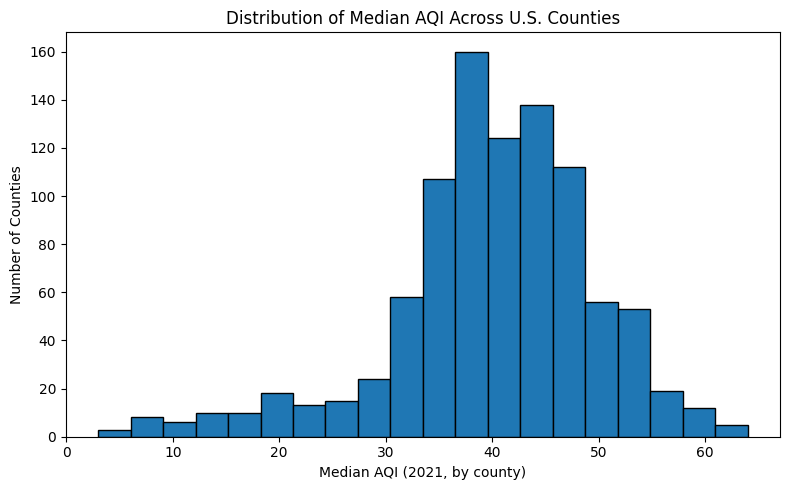

In [6]:
aqi_vals = mergeFull["Median AQI"].dropna() 
aqi_vals = aqi_vals[(aqi_vals >= 0) & (aqi_vals <= aqi_vals.quantile(0.99))] 

plt.figure(figsize=(8,5)) 
plt.hist(aqi_vals, bins=20, edgecolor="black") 
plt.xlabel("Median AQI (2021, by county)") 
plt.ylabel("Number of Counties") 
plt.title("Distribution of Median AQI Across U.S. Counties") 
plt.tight_layout() 
plt.show() 

In [7]:
pivot_state = mergeFull.pivot_table( 
    values=["Median AQI", "Percent_COPD"], #these are columns we want the averages of 
    index="State", #this will group the rows by state 
    aggfunc="mean" #this will take the mean for each state 
) 
pivot_state.head() 

,Median AQI,Percent_COPD
State,,
Alabama,40.533333,7.386667
Arizona,50.384615,6.907692
Arkansas,42.636364,8.000000
California,51.264151,5.630189
Colorado,39.709677,5.406452


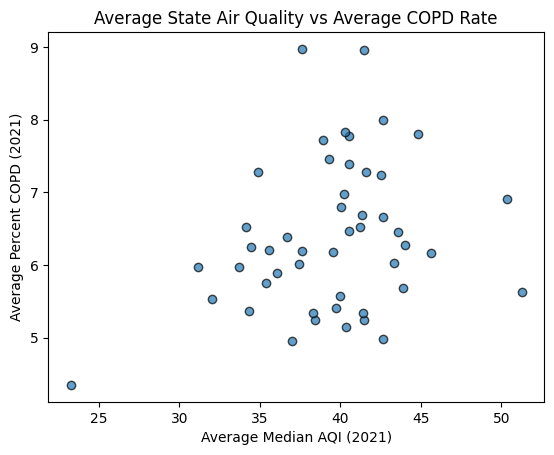

In [8]:
fig, ax = plt.subplots() 

plt.scatter( 
    pivot_state["Median AQI"], 
    pivot_state["Percent_COPD"], 
    alpha=0.7, 
    edgecolor="black" 
) 
plt.title("Average State Air Quality vs Average COPD Rate") 
plt.xlabel("Average Median AQI (2021)") 
plt.ylabel("Average Percent COPD (2021)") 
plt.show() 


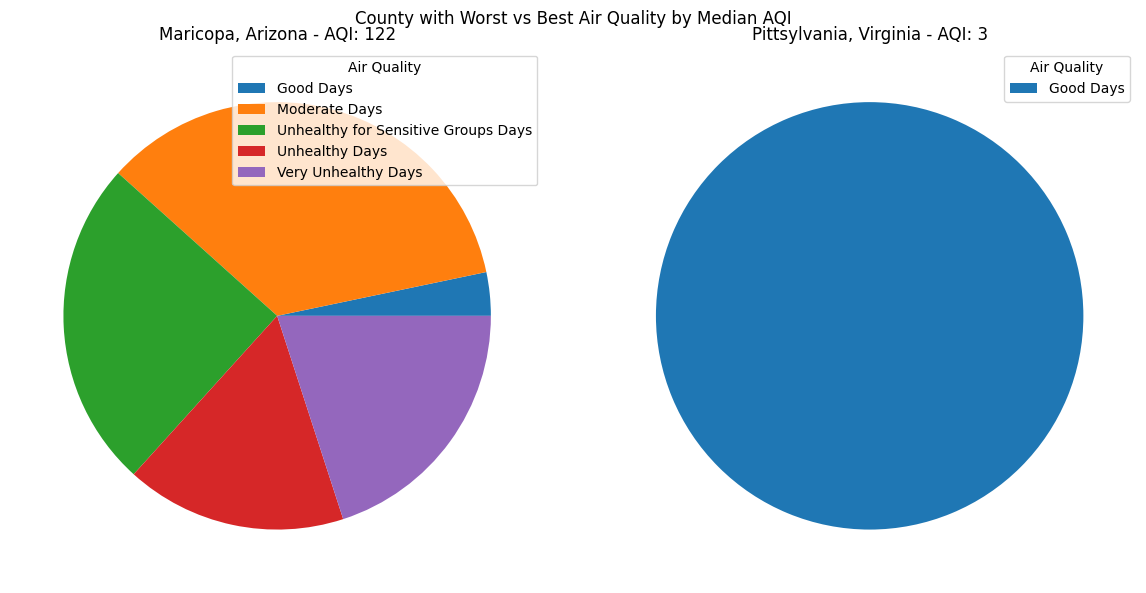

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# identify the days to plot
day_values = ['Good Days', 'Moderate Days', 'Unhealthy for Sensitive Groups Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days']

# filter and find just the best and worst counties in 2021 by median aqi
worst_county = mergeFull.loc[mergeFull['Median AQI'].idxmax(), :]
best_county = mergeFull.loc[mergeFull['Median AQI'].idxmin(), :]

# then get the column data values for the best and worst counties
worst_county_values = mergeFull.loc[mergeFull['Median AQI'].idxmax(), day_values]
best_county_values = mergeFull.loc[mergeFull['Median AQI'].idxmin(), day_values]

# Create a pie chart with the best and worst values
worst_wedges, _ = ax[0].pie(worst_county_values)
best_wedges, _ = ax[1].pie(best_county_values)

# Create plot titles
fig.suptitle("County with Worst vs Best Air Quality by Median AQI")
ax[0].set_title(f"{worst_county.County}, {worst_county.State} - AQI: {worst_county['Median AQI']}")
ax[1].set_title(f"{best_county.County}, {best_county.State} - AQI: {best_county['Median AQI']}")

#create
ax[0].legend(worst_wedges, day_values[:-1], title="Air Quality", loc='best') # displays all but hazardous days
ax[1].legend(best_wedges, day_values[:1], title="Air Quality", loc='best') # only display good days, since it only has good days on legend

fig.tight_layout()

<Figure size 1400x600 with 0 Axes>

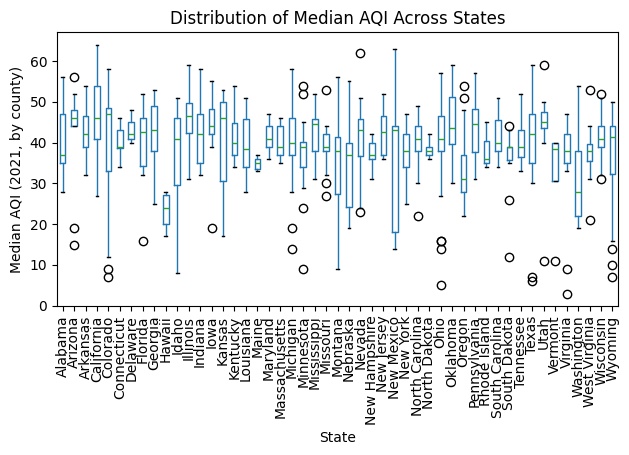

In [10]:
df_aqi = mergeFull[['State', 'Median AQI']].dropna() 
df_aqi = df_aqi[df_aqi['Median AQI'] <= df_aqi['Median AQI'].quantile(0.99)] 

plt.figure(figsize=(14,6)) 

df_aqi.boxplot(by='State', column='Median AQI', vert=True, grid=False) 

plt.xticks(rotation=90) 
plt.ylabel("Median AQI (2021, by county)") 
plt.title("Distribution of Median AQI Across States") 
plt.suptitle("")  
plt.tight_layout() 
plt.show() 

In [11]:
import json

with open("./data/geojson-counties-fips.json", 'r') as f:
    geojson = json.load(f)


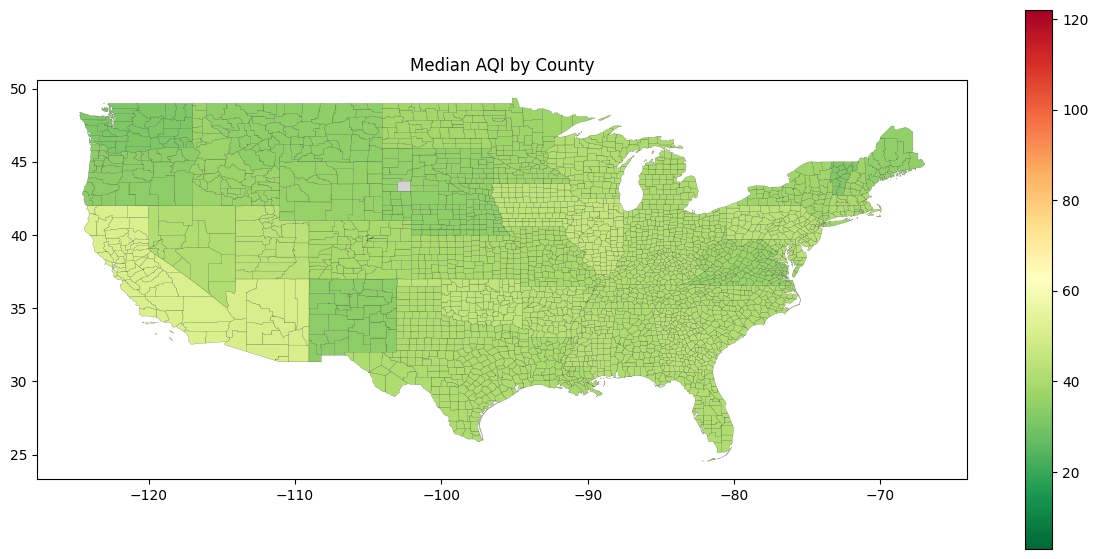

In [12]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

patches, colors = [], []

pivot_aqi_state = mergeFull.pivot_table( 
    values=["Median AQI"], #these are columns we want the averages of 
    index="State", #this will group the rows by state 
    aggfunc="mean", #this will take the mean for each state 
    dropna=True
).reset_index()

# find the min and max aqi so values can be scalled 0 to 1
min_aqi, max_aqi = mergeFull['Median AQI'].min(), mergeFull['Median AQI'].max()

# get the red yellow green color map and reverse it so that 'bad' ie a high AQI value will be shown in red and lower values will be show in green
cmap = plt.get_cmap('RdYlGn').reversed()

# for each county entry in the json's feature array
for feature in geojson['features']:
    #get the fips code which identifies the county
    fips = int(feature['id'])

    # get the aqi if it exists
    # median_aqi = mergeFull[mergeFull.FIPStxt == fips]['Median AQI'].values
    try:
        median_aqi = pivot_aqi_state[pivot_aqi_state.State == popDF[popDF.FIPStxt == fips].State.values[0]].values
    except:
        median_aqi = []
    # print(median_aqi)
    # color it either based on the pallete or gray if there is no data for the county
    if len(median_aqi):
        color = cmap((median_aqi[0][1] - min_aqi) / (max_aqi - min_aqi))
    else:
        color = '#d3d3d3'
    
    # ignore Alaska, Hawaii, and Peurto Rico as they make the map tiny
    if feature['properties']['STATE'] in ['02', '15', '72']:
        continue

    # Handle either a polygon, or a multi-polygon for states with islands
    if feature['geometry']['type'] == 'Polygon':
        polys = [feature['geometry']['coordinates']]
    else:
        polys = feature['geometry']['coordinates']
    
    # append the matplotlib polygon to a list
    for poly in polys:
        patches.append(Polygon(poly[0], closed=True))
        colors.append(color)

# make plot
fig, ax = plt.subplots(figsize=(15, 7))
# add a color bar since I am just plotting patches, no actual plot
fig.colorbar(ScalarMappable(norm=Normalize(min_aqi, max_aqi), cmap=cmap), ax=ax)
# add all of the patches
ax.add_collection(PatchCollection(patches, facecolors=colors, edgecolor='black', linewidth=0.1)) # add all patches
# autoscale to show all of the patches
ax.autoscale()
ax.set_aspect('equal') # else it is very warped

ax.set_title("Median AQI by County")
plt.show()

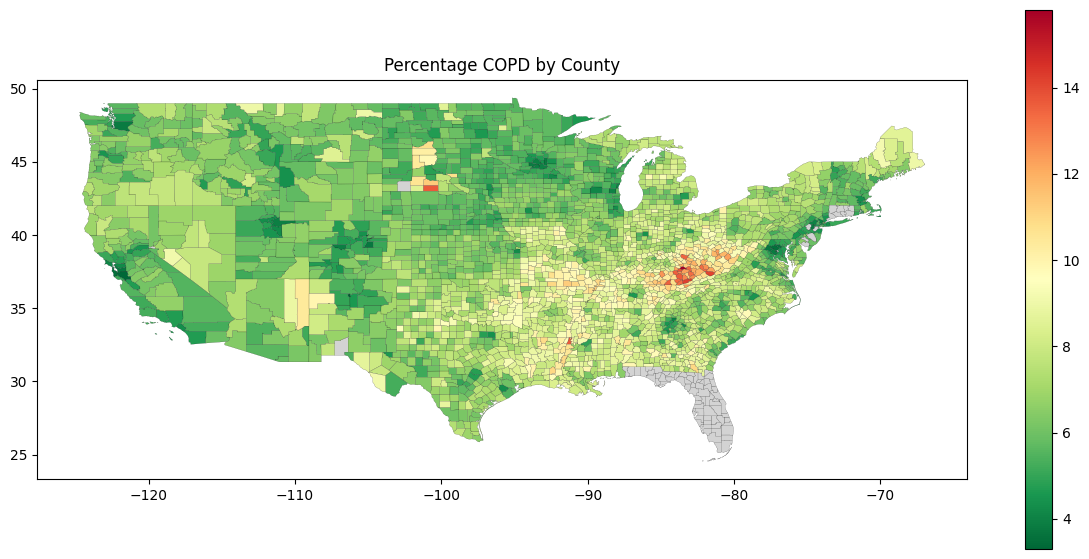

In [13]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

patches, colors = [], []

COPDMerge.dropna(inplace=True)

# find the min and max aqi so values can be scalled 0 to 1
min_aqi, max_aqi = COPDMerge['Percent_COPD'].min(), COPDMerge['Percent_COPD'].max()

# get the red yellow green color map and reverse it so that 'bad' ie a high AQI value will be shown in red and lower values will be show in green
cmap = plt.get_cmap('RdYlGn').reversed()

# for each county entry in the json's feature array
for feature in geojson['features']:
    #get the fips code which identifies the county
    fips = int(feature['id'])

    # get the aqi if it exists
    percent_copd = COPDMerge[COPDMerge.FIPStxt == fips]['Percent_COPD'].values

    # color it either based on the pallete or gray if there is no data for the county
    if len(percent_copd):
        color = cmap((percent_copd[0] - min_aqi) / (max_aqi - min_aqi))
    else:
        color = '#d3d3d3'
    
    # ignore Alaska, Hawaii, and Peurto Rico as they make the map tiny
    if feature['properties']['STATE'] in ['02', '15', '72']:
        continue

    # Handle either a polygon, or a multi-polygon for states with islands
    if feature['geometry']['type'] == 'Polygon':
        polys = [feature['geometry']['coordinates']]
    else:
        polys = feature['geometry']['coordinates']
    
    # append the matplotlib polygon to a list
    for poly in polys:
        patches.append(Polygon(poly[0], closed=True))
        colors.append(color)

# make plot
fig, ax = plt.subplots(figsize=(15, 7))
# add a color bar since I am just plotting patches, no actual plot
fig.colorbar(ScalarMappable(norm=Normalize(min_aqi, max_aqi), cmap=cmap), ax=ax)
# add all of the patches
ax.add_collection(PatchCollection(patches, facecolors=colors, edgecolor='black', linewidth=0.1)) # add all patches
# autoscale to show all of the patches
ax.autoscale()
ax.set_aspect('equal') # else it is very warped

ax.set_title("Percentage COPD by County")
plt.show()